<a href="https://colab.research.google.com/github/Aleksandr62aa/AI_ML_DL/blob/main/CNN_Tensorflow_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classifying images using TensorFlow**

**Importing libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import torch

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Fixed seed
np.random.seed(11)

**download the dataset**

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
dataset_dir = pathlib.Path(dataset_dir).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


## **Total images dataset**

In [ ]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Total images: {image_count}")

Total images: 3670


**Train Val cache dataset**

In [ ]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


**Create model**

In [ ]:
num_classes = len(class_names)
model = Sequential([

	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**Train model**


In [ ]:
epochs = 10

history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

Epoch 1/10
92/92 [==============================] - 21s 35ms/step - loss: 1.3476 - accuracy: 0.4275 - val_loss: 1.0789 - val_accuracy: 0.5777
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 1.0180 - accuracy: 0.6080 - val_loss: 0.9480 - val_accuracy: 0.6226
Epoch 3/10
92/92 [==============================] - 2s 19ms/step - loss: 0.8158 - accuracy: 0.6894 - val_loss: 0.8818 - val_accuracy: 0.6526
Epoch 4/10
92/92 [==============================] - 2s 19ms/step - loss: 0.6046 - accuracy: 0.7783 - val_loss: 0.8970 - val_accuracy: 0.6567
Epoch 5/10
92/92 [==============================] - 2s 21ms/step - loss: 0.4023 - accuracy: 0.8621 - val_loss: 1.0460 - val_accuracy: 0.6567
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.2464 - accuracy: 0.9176 - val_loss: 1.1781 - val_accuracy: 0.6526
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 0.1497 - accuracy: 0.9513 - val_loss: 1.2995 - val_accuracy: 0.6253
Epoch 8/10
9

**Visualize training and validation results**

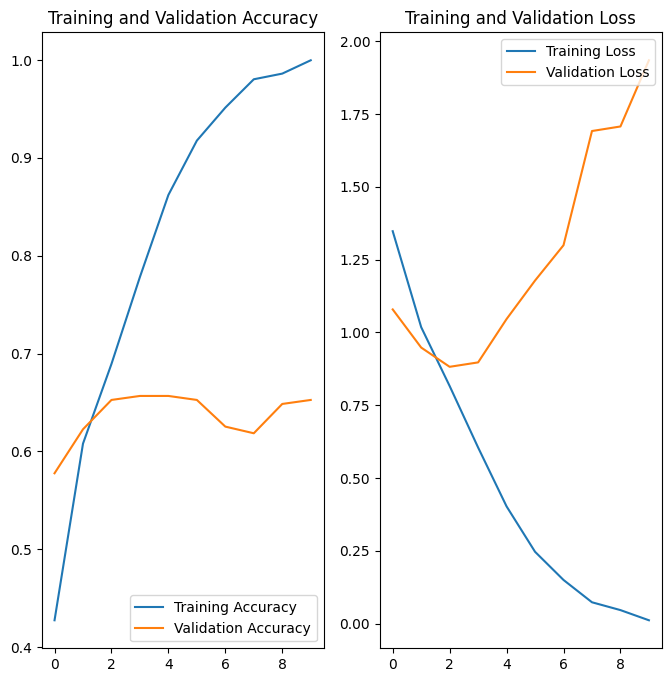

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Solving the Overfitting Problem**

**Adding augmentation and regularization (Dropout)**

In [ ]:
model = Sequential([

	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# augmentation
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),

	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# regularization
	layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 180, 180, 3)       0         
 trast)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)     

**Retraining the model with new layers**

Epoch 1/20
92/92 [==============================] - 6s 31ms/step - loss: 1.2803 - accuracy: 0.4533 - val_loss: 1.0955 - val_accuracy: 0.5599
Epoch 2/20
92/92 [==============================] - 3s 28ms/step - loss: 1.0818 - accuracy: 0.5736 - val_loss: 1.0207 - val_accuracy: 0.5967
Epoch 3/20
92/92 [==============================] - 3s 29ms/step - loss: 0.9672 - accuracy: 0.6127 - val_loss: 1.0570 - val_accuracy: 0.5886
Epoch 4/20
92/92 [==============================] - 3s 29ms/step - loss: 0.9186 - accuracy: 0.6458 - val_loss: 0.9219 - val_accuracy: 0.6649
Epoch 5/20
92/92 [==============================] - 3s 28ms/step - loss: 0.8487 - accuracy: 0.6717 - val_loss: 0.8540 - val_accuracy: 0.6635
Epoch 6/20
92/92 [==============================] - 3s 28ms/step - loss: 0.8073 - accuracy: 0.6928 - val_loss: 0.7949 - val_accuracy: 0.6703
Epoch 7/20
92/92 [==============================] - 3s 38ms/step - loss: 0.7548 - accuracy: 0.7098 - val_loss: 0.7851 - val_accuracy: 0.6894
Epoch 8/20
92

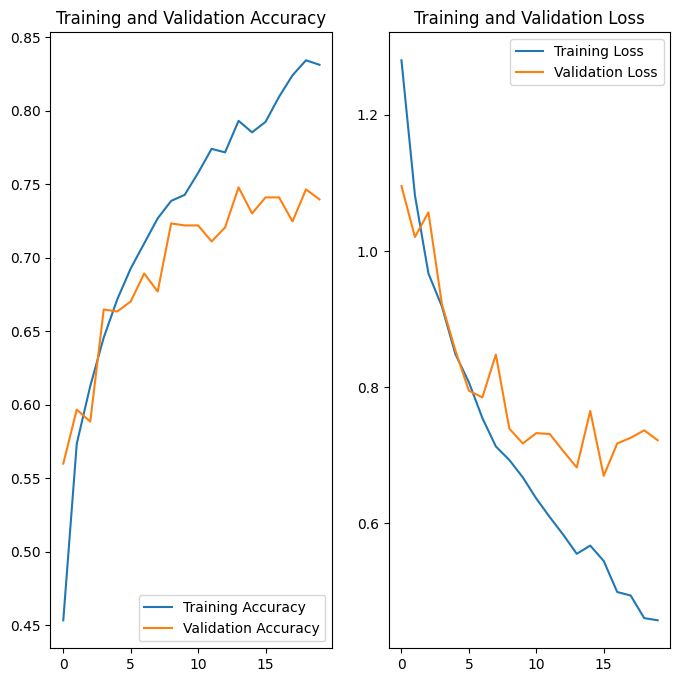

In [ ]:
# train the model
epochs = 20
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inference**

1/1 [==============================] - 0s 161ms/step
Most likely in the image sunflowers (99.43% probability)


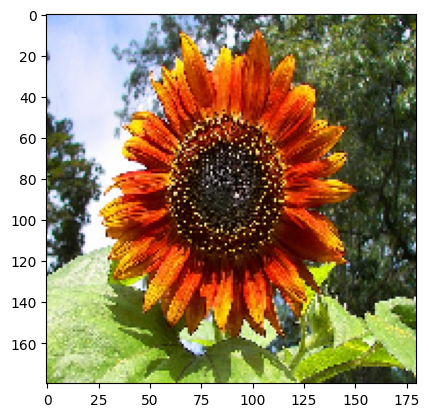

In [ ]:
# load image
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print inference result
print("Most likely in the image {} ({:.2f}% probability)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# show the image itself
plt.imshow(img);

1/1 [==============================] - 0s 27ms/step
Most likely in the image sunflowers (97.70% probability)


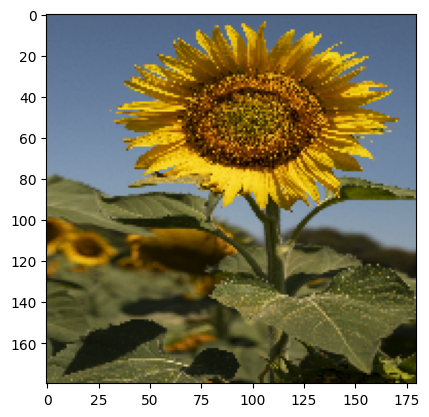

In [ ]:
# load image
img = tf.keras.utils.load_img("test-image.jpg", target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print inference result
print("Most likely in the image {} ({:.2f}% probability)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# show the image itself
plt.imshow(img);

**Exporting a model file to your computer**

In [ ]:
from google.colab import files

model_file_name = "my_flowers_model.keras"

# save model
model.save(model_file_name)

# download model
files.download(model_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>